In [9]:
#いろいろインポート
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression as LR

import datetime

pd.set_option('display.width',400)#勝手に改行コードを入れられるのを防ぐ

### dateのカラムから分布や時期の基礎集計と新規変数の検討

In [10]:
#モデルスコアデータの読み込み
place='asiya'
train_df = pd.read_csv('../csv/train_{}.csv'.format(place))
train_df=train_df.drop(["Unnamed: 0"],axis=1)#csvファイルについている名無しの列を削除
train_df['date']=pd.to_datetime(train_df['date'])#文字列なのでdateを日付型に変換
display(train_df)

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,2012-04-03,1160.0,1,3959,35.0,0.14,3.0,0.541,1,43.0,...,2,4037,34.0,0.19,29.0,0.396,1,47.0,3,6
1,2012-04-03,2960.0,2,3251,46.0,0.18,10.0,0.450,1,36.0,...,3,4097,30.0,0.20,1.0,0.226,1,52.0,2,3
2,2012-04-03,21490.0,3,3662,43.0,0.16,4.0,0.480,1,68.0,...,4,3925,37.0,0.22,48.0,0.336,1,66.0,2,44
3,2012-04-03,5100.0,4,4266,27.0,0.17,21.0,0.506,1,46.0,...,2,4363,27.0,0.17,38.0,0.366,1,58.0,3,62
4,2012-04-03,1980.0,5,4112,32.0,0.21,40.0,0.439,1,39.0,...,2,4573,24.0,0.15,53.0,0.514,1,75.0,4,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19337,2020-03-27,54960.0,6,3503,51.0,0.19,26.0,0.156,1,44.0,...,2,3885,46.0,0.15,20.0,0.348,1,18.0,3,83
19338,2020-03-27,650.0,8,3873,44.0,0.17,41.0,0.426,1,61.0,...,4,3694,48.0,0.17,12.0,0.200,1,29.0,2,14
19339,2020-03-27,3930.0,9,3618,47.0,0.18,8.0,0.464,0,62.0,...,3,4252,37.0,0.17,18.0,0.279,1,23.0,2,10
19340,2020-03-27,1430.0,10,3710,46.0,0.17,45.0,0.247,1,52.0,...,2,4123,39.0,0.19,35.0,0.542,0,32.0,4,25


In [11]:
#新規変数の追加（月番号(month)、num_date,range_date）
#dateの型変換したものから月、年の情報の抽出
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day

#何日間の大会なのか(range_date)と大会(num_date)の何日目なのかの情報を追加

num_date=1
num_date_arr=[]
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtarainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して、そのレース日番号を加算
            num_date+=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
        else:#想定していた日付でない(違う大会になった)場合はレース日をリセット
            num_date=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            
train_df['num_date']=num_date_arr
#train_df['range_date']=


In [14]:
range_races=0#大会中の取得できたレースの数
range_date=1#大会の開催日数
range_date_arr=[]
range_date_arr_2=[]#for文中で繰り返し上書きさせる用の配列
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtrainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        range_races+=1
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        #num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して終了
            range_date+=1
            range_races+=1
            last_race_date=row['date']#前回レース日を上書き
            next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日  
        else:#想定していた日付でない(違う大会になった)場合は現在のrange_dateをもとに前の大会のレースに大会開催日数を持たせる。

            range_date_arr_2=[range_date]*range_races
            for num in range_date_arr_2:
                range_date_arr.append(num)
            range_races=1#大会中の取得できたレースの数
            range_date=1#大会の開催日数
            last_race_date=row['date']#前回レース日を上書き
            next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            print(next_date)
            
range_date_arr_2=[range_date]*range_races#最後の日は日付の変わり絵が発生しないので特別処理
for num in range_date_arr_2:
    range_date_arr.append(num)
train_df['range_date']=range_date_arr
#train_df['range_date']=


         date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
81 2012-04-13    910.0            1        3730         40.0            0.17        14.0         0.355             1        27.0  ...         0.225             1        59.0             2           9  2012      4   13         2           4
82 2012-04-13   9560.0            2        3921         37.0            0.18        59.0         0.389             1        18.0  ...         0.323             1        23.0             2          32  2012      4   13         2           4
83 2012-04-13   9780.0            3        4120         31.0            0.17         6.0         0.359             1        72.0  ...         0.312             1        65.0             2          57  2012      4   13         2           4
84 2012-04-13    660.0            4     

          date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
629 2012-07-13   5840.0            1        4218         31.0            0.16        11.0         0.506             1        14.0  ...         0.000             1        52.0             1          13  2012      7   13         2           5
630 2012-07-13   9670.0            2        3443         43.0            0.17        54.0         0.515             1        20.0  ...         0.247             1        72.0             2          82  2012      7   13         2           5
631 2012-07-13   1050.0            3        3662         43.0            0.16         1.0         0.480             1        21.0  ...         0.252             1        73.0             2          13  2012      7   13         2           5
632 2012-07-13    800.0            4

[12 rows x 57 columns]
           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
1129 2012-10-01   1110.0            1        3268         47.0            0.18        22.0         0.308             1        49.0  ...         0.153             1        30.0             2           2  2012     10    1         2           6
1130 2012-10-01   5670.0            2        3795         39.0            0.14        26.0         0.520             1        29.0  ...         0.262             1        38.0             2          16  2012     10    1         2           6
1131 2012-10-01  10070.0            3        3833         38.0            0.16        60.0         0.458             1        37.0  ...         0.085             1        22.0             1          81  2012     10    1         2           6
1132 2012

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
1569 2012-12-16   1510.0            1        4311         28.0            0.16         1.0         0.441             1        13.0  ...         0.000             1        11.0             1          10  2012     12   16         2           4
1570 2012-12-16   1790.0            2        3616         39.0            0.18         2.0         0.305             1        33.0  ...         0.000             1        24.0             1           9  2012     12   16         2           4
1571 2012-12-16    400.0            3        3992         34.0            0.13        43.0         0.482             1        49.0  ...         0.290             1        31.0             2           7  2012     12   16         2           4
1572 2012-12-16    580.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
1953 2012-02-19    530.0            1        3833         38.0            0.16        36.0         0.458             1        37.0  ...         0.209             1        55.0             2           2  2012      2   19         2           5
1954 2012-02-19  26790.0            2        3903         35.0            0.15         5.0         0.500             1        38.0  ...         0.218             0        39.0             2          29  2012      2   19         2           5
1955 2012-02-19   1610.0            3        3866         37.0            0.15        51.0         0.344             1        27.0  ...         0.351             1        21.0             3          43  2012      2   19         2           5
1956 2012-02-19  16130.0        

[11 rows x 57 columns]
           date   money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
2304 2013-04-20   750.0            1        4205         31.0            0.15        61.0         0.585             1        76.0  ...         0.221             1        48.0             2          10  2013      4   20         2           5
2305 2013-04-20  1480.0            2        3297         46.0            0.20        26.0         0.666             1        42.0  ...         0.229             1        34.0             2          63  2013      4   20         2           5
2306 2013-04-20   620.0            3        3226         48.0            0.17        63.0         0.289             1        47.0  ...         0.095             0        23.0             1          53  2013      4   20         2           5
2307 2013-04-

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
2495 2013-05-18   4020.0            1        3641         42.0            0.17         2.0         0.507             1        48.0  ...         0.284             1        31.0             2          14  2013      5   18         2           4
2496 2013-05-18   1020.0            2        3401         46.0            0.18        30.0         0.423             1        32.0  ...         0.224             1        34.0             2           6  2013      5   18         2           4
2497 2013-05-18   2160.0            3        4057         34.0            0.16        23.0         0.416             1        41.0  ...         0.592             1        26.0             4          57  2013      5   18         2           4
2498 2013-05-18    550.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
2856 2013-07-20   2210.0            1        4236         30.0            0.15        28.0         0.495             1        27.0  ...         0.349             1        28.0             3           4  2013      7   20         2           4
2857 2013-07-20   9620.0            2        3808         38.0            0.16        64.0         0.174             1        29.0  ...         0.299             1        42.0             2          39  2013      7   20         2           4
2858 2013-07-20  79770.0            3        4505         25.0            0.18        21.0         0.404             1        25.0  ...         0.162             1        43.0             2          78  2013      7   20         2           4
2859 2013-07-20    630.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
3031 2013-08-17    500.0            1        4096         32.0            0.16        17.0         0.496             1        27.0  ...         0.190             0        11.0             2           5  2013      8   17         2           6
3032 2013-08-17   1040.0            2        3579         41.0            0.17        19.0         0.472             0        45.0  ...         0.310             0        35.0             3           4  2013      8   17         2           6
3033 2013-08-17  77690.0            3        3442         44.0            0.18         4.0         0.435             1        26.0  ...         0.189             1        34.0             2         104  2013      8   17         2           6
3034 2013-08-17   1510.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
3458 2013-10-25    360.0            1        3574         41.0            0.18        63.0         0.524             1        62.0  ...         0.267             1        43.0             2           1  2013     10   25         2           6
3459 2013-10-25    860.0            2        3107         50.0            0.19         8.0         0.376             1        38.0  ...         0.350             1        26.0             3          10  2013     10   25         2           6
3460 2013-10-25  15860.0            3        3992         35.0            0.14        50.0         0.438             1        52.0  ...         0.162             1        51.0             2          20  2013     10   25         2           6
3461 2013-10-25   6150.0        

[11 rows x 57 columns]
           date   money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
3989 2013-01-17  3770.0            1        3801         39.0            0.19        26.0         0.308             0        71.0  ...         0.390             0        59.0             3         102  2013      1   17         2           6
3990 2013-01-17  4390.0            2        3900         36.0            0.18        46.0         0.516             0        33.0  ...         0.048             0        50.0             1          22  2013      1   17         2           6
3991 2013-01-17  3400.0            3        2983         54.0            0.17        17.0         0.367             0        65.0  ...         0.197             0        45.0             2           5  2013      1   17         2           6
3992 2013-01-

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
4485 2014-04-27   1130.0            1        4136         34.0            0.16        59.0         0.453             1        66.0  ...         0.303             1        18.0             2           5  2014      4   27         2           6
4486 2014-04-27  38580.0            2        3121         53.0            0.19        62.0         0.284             1        19.0  ...         0.207             1        15.0             2          31  2014      4   27         2           6
4487 2014-04-27    940.0            4        4236         31.0            0.11        43.0         0.666             1        37.0  ...         0.000             1        71.0             1           1  2014      4   27         2           6
4488 2014-04-27    930.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
4958 2014-07-25  80400.0            1        3872         38.0            0.18        49.0         0.503             1        70.0  ...         0.222             1        52.0             2          50  2014      7   25         2           6
4959 2014-07-25  23280.0            2        3566         44.0            0.18        13.0         0.391             1        44.0  ...         0.288             1        28.0             2          37  2014      7   25         2           6
4960 2014-07-25    780.0            4        3618         41.0            0.15        40.0         0.533             0        37.0  ...         0.040             0        33.0             1          11  2014      7   25         2           6
4961 2014-07-25    700.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
5431 2014-10-01  11310.0            1        4545         26.0            0.17        11.0         0.428             1        19.0  ...         0.338             1        16.0             3         109  2014     10    1         2           6
5432 2014-10-01  85940.0            2        4259         30.0            0.15        32.0         0.521             1        68.0  ...         0.306             1        32.0             2          97  2014     10    1         2           6
5433 2014-10-01  15470.0            3        3523         46.0            0.18        36.0         0.291             1        47.0  ...         0.193             1        41.0             2          85  2014     10    1         2           6
5434 2014-10-01    800.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
5815 2014-11-29   2700.0            1        4264         30.0            0.15        54.0         0.438             1        55.0  ...         0.092             1        26.0             1          14  2014     11   29         2           6
5816 2014-11-29    490.0            2        4148         32.0            0.17        52.0         0.414             1        17.0  ...         0.315             1        47.0             2           9  2014     11   29         2           6
5817 2014-11-29    800.0            3        4395         28.0            0.17        49.0         0.354             1        53.0  ...         0.261             1        27.0             2           7  2014     11   29         2           6
5818 2014-11-29    620.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
6185 2014-01-25    640.0            1        3713         40.0            0.15        24.0         0.604             1        18.0  ...         0.000             1        78.0             1           9  2014      1   25         2           4
6186 2014-01-25  11730.0            2        3875         38.0            0.16        28.0         0.320             1        45.0  ...         0.273             1        19.0             2          49  2014      1   25         2           4
6187 2014-01-25   2250.0            3        3538         46.0            0.18        37.0         0.422             1        11.0  ...         0.168             1        55.0             2          41  2014      1   25         2           4
6188 2014-01-25    750.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
6526 2015-04-02   6310.0            3        3455         44.0            0.20        60.0         0.341             1        72.0  ...         0.163             0        43.0             2          10  2015      4    2         2           5
6527 2015-04-02    490.0            4        4008         36.0            0.16        42.0         0.462             1        32.0  ...         0.051             0        39.0             1           1  2015      4    2         2           5
6528 2015-04-02  30690.0            6        3885         41.0            0.19        32.0         0.391             1        42.0  ...         0.266             1        16.0             2         103  2015      4    2         2           5
6529 2015-04-02  31720.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
7013 2015-06-21    950.0            1        3997         36.0            0.19        31.0         0.479             1        71.0  ...         0.267             1        23.0             2           2  2015      6   21         2           5
7014 2015-06-21  36660.0            2        4216         30.0            0.16        33.0         0.445             1        12.0  ...         0.213             1        55.0             2          81  2015      6   21         2           5
7015 2015-06-21    440.0            4        3257         48.0            0.14        63.0         0.663             1        66.0  ...         0.070             1        41.0             1           6  2015      6   21         2           5
7016 2015-06-21   1320.0        

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
7549 2015-09-22   1710.0            1        4330         32.0            0.14        65.0         0.488             1        74.0  ...         0.229             1        56.0             2           9  2015      9   22         2           4
7550 2015-09-22  15720.0            2        3211         53.0            0.17         9.0         0.262             1        65.0  ...         0.214             1        36.0             2          26  2015      9   22         2           4
7551 2015-09-22  16560.0            3        4058         36.0            0.19        43.0         0.218             1        61.0  ...         0.209             1        21.0             2          85  2015      9   22         2           4
7552 2015-09-22   1410.0        

[12 rows x 57 columns]
           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
8093 2015-12-25   4450.0            1        4096         34.0            0.17        33.0         0.462             1        19.0  ...         0.066             1        47.0             1          15  2015     12   25         2           4
8094 2015-12-25   3160.0            3        3454         44.0            0.17         5.0         0.407             1        51.0  ...         0.101             1        68.0             2          89  2015     12   25         2           4
8095 2015-12-25   1250.0            4        4089         35.0            0.14        40.0         0.552             1        35.0  ...         0.063             1        13.0             1           7  2015     12   25         2           4
8096 2015

[11 rows x 57 columns]
           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
8527 2015-03-12    780.0            1        4468         29.0            0.16        26.0         0.456             1        36.0  ...         0.267             1        50.0             2           2  2015      3   12         2           6
8528 2015-03-12  10660.0            2        4152         35.0            0.19        46.0         0.294             1        21.0  ...         0.233             1        32.0             2          69  2015      3   12         2           6
8529 2015-03-12   3630.0            3        4645         35.0            0.13        49.0         0.443             1        63.0  ...         0.285             1        24.0             2           6  2015      3   12         2           6
8530 2015

[10 rows x 57 columns]
           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
8957 2016-05-23   3290.0            1        4424         31.0            0.16        23.0         0.458             1        50.0  ...         0.135             1        39.0             2           8  2016      5   23         2           4
8958 2016-05-23   3220.0            2        4177         34.0            0.17        46.0         0.319             1        26.0  ...         0.206             1        68.0             2          68  2016      5   23         2           4
8959 2016-05-23  19380.0            3        3382         48.0            0.19        32.0         0.259             1        49.0  ...         0.345             1        47.0             3          71  2016      5   23         2           4
8960 2016

[12 rows x 57 columns]
           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
9468 2016-08-14   2380.0            1        3944         37.0            0.18        49.0         0.514             1        41.0  ...         0.261             1        47.0             2          44  2016      8   14         2           6
9469 2016-08-14  39130.0            2        4522         29.0            0.14        48.0         0.506             1        12.0  ...         0.383             1        15.0             3          94  2016      8   14         2           6
9470 2016-08-14   4070.0            3        4736         25.0            0.18        47.0         0.321             1        39.0  ...         0.319             1        44.0             2          86  2016      8   14         2           6
9471 2016

           date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
9950 2016-11-14   1180.0            1        4719         22.0            0.13        60.0         0.569             1        12.0  ...         0.584             0        62.0             4           6  2016     11   14         2           6
9951 2016-11-14  11440.0            2        4442         30.0            0.18        29.0         0.422             1        24.0  ...         0.521             1        21.0             4          13  2016     11   14         2           6
9952 2016-11-14   3400.0            3        4808         28.0            0.19        22.0         0.336             1        59.0  ...         0.551             1        19.0             4          19  2016     11   14         2           6
9953 2016-11-14   6970.0        

            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
10571 2016-02-27   1640.0            1        3898         40.0            0.16        34.0         0.516             1        48.0  ...         0.487             1        75.0             4           5  2016      2   27         2           6
10572 2016-02-27   4630.0            2        4586         26.0            0.12        48.0         0.451             1        46.0  ...         0.388             1        49.0             3           8  2016      2   27         2           6
10573 2016-02-27   5740.0            3        3555         44.0            0.16         3.0         0.516             1        40.0  ...         0.568             1        54.0             4          65  2016      2   27         2           6
10574 2016-02-27  68710.0   

[11 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
11128 2017-05-18  11680.0            1        3297         50.0            0.20        49.0         0.477             1        22.0  ...         0.218             1        30.0             2          65  2017      5   18         2           6
11129 2017-05-18  13240.0            2        3522         49.0            0.18        60.0         0.466             1        23.0  ...         0.137             1        16.0             2          82  2017      5   18         2           6
11130 2017-05-18   1790.0            4        4140         37.0            0.18        21.0         0.500             1        59.0  ...         0.367             1        36.0             3          12  2017      5   18         2           6
11131

[12 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
11598 2017-08-14   1010.0            1        4522         30.0            0.15        16.0         0.553             1        57.0  ...         0.180             1        54.0             2          13  2017      8   14         2           6
11599 2017-08-14   1120.0            2        3683         44.0            0.14        57.0         0.346             1        13.0  ...         0.303             1        60.0             2          77  2017      8   14         2           6
11600 2017-08-14   1400.0            3        4736         26.0            0.16        61.0         0.442             1        34.0  ...         0.028             1        71.0             1          43  2017      8   14         2           6
11601

[12 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
11988 2017-10-15  15050.0            1        4314         33.0            0.15        34.0         0.396             1        47.0  ...         0.166             1        33.0             2          43  2017     10   15         2           6
11989 2017-10-15   1350.0            2        3769         44.0            0.17        52.0         0.393             1        37.0  ...         0.000             0        57.0             1          62  2017     10   15         2           6
11990 2017-10-15   1000.0            3        4069         37.0            0.16        32.0         0.406             1        15.0  ...         0.352             1        61.0             3          82  2017     10   15         2           6
11991

            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
12417 2017-12-26    810.0            1        3576         45.0            0.16        32.0         0.564             1        30.0  ...         0.000             1        43.0             1           5  2017     12   26         2           4
12418 2017-12-26   3320.0            2        4314         33.0            0.15        34.0         0.396             1        49.0  ...         0.309             1        21.0             2          77  2017     12   26         2           4
12419 2017-12-26   3120.0            4        3514         50.0            0.16        39.0         0.468             1        14.0  ...         0.404             1        65.0             3          62  2017     12   26         2           4
12420 2017-12-26   2030.0   

[10 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
13008 2018-04-02    440.0            1        3188         57.0            0.17        33.0         0.512             0        65.0  ...         0.109             0        27.0             2           1  2018      4    2         2           6
13009 2018-04-02  40850.0            2        4014         39.0            0.17        19.0         0.368             0        66.0  ...         0.161             0        26.0             2          46  2018      4    2         2           6
13010 2018-04-02   1820.0            3        3801         44.0            0.18        58.0         0.383             0        33.0  ...         0.109             0        16.0             2           5  2018      4    2         2           6
13011

[11 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
13422 2018-06-15  10670.0            1        3901         41.0            0.18        45.0         0.419             1        62.0  ...         0.252             1        56.0             2          20  2018      6   15         2           6
13423 2018-06-15   1420.0            2        4579         29.0            0.15        44.0         0.480             1        57.0  ...         0.194             1        15.0             2          61  2018      6   15         2           6
13424 2018-06-15  17130.0            3        3975         41.0            0.19        31.0         0.368             1        60.0  ...         0.212             1        74.0             2          73  2018      6   15         2           6
13425

[11 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
13835 2018-08-17  12840.0            1        3784         42.0            0.17        59.0         0.377             1        61.0  ...         0.015             1        56.0             1          62  2018      8   17         2           6
13836 2018-08-17   1190.0            2        4027         40.0            0.17        32.0         0.443             1        51.0  ...         0.233             1        40.0             2          63  2018      8   17         2           6
13837 2018-08-17   3400.0            3        3401         51.0            0.18        46.0         0.417             1        33.0  ...         0.213             1        43.0             2          10  2018      8   17         2           6
13838

[12 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
14298 2018-11-02   6210.0            1        3582         45.0            0.17        65.0         0.524             1        71.0  ...         0.098             1        31.0             2          41  2018     11    2         2           4
14299 2018-11-02  58680.0            2        3212         56.0            0.16        28.0         0.409             1        33.0  ...         0.344             1        65.0             2         106  2018     11    2         2           4
14300 2018-11-02   4780.0            4        4061         39.0            0.15        14.0         0.490             1        20.0  ...         0.000             1        66.0             1          11  2018     11    2         2           4
14301

            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
14727 2018-01-10    610.0            1        4376         34.0            0.16        62.0         0.475             1        25.0  ...         0.348             1        58.0             2           9  2018      1   10         2           6
14728 2018-01-10   1580.0            2        4521         31.0            0.17        54.0         0.359             1        73.0  ...         0.282             1        70.0             2          76  2018      1   10         2           6
14729 2018-01-10  15440.0            3        4703         30.0            0.15        57.0         0.429             1        24.0  ...         0.057             1        52.0             2          51  2018      1   10         2           6
14730 2018-01-10    700.0   

            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
15369 2019-05-05    940.0            1        3685         45.0            0.14        34.0         0.418             1        62.0  ...         0.315             1        39.0             3           8  2019      5    5         2           6
15370 2019-05-05    740.0            2        4214         35.0            0.16        20.0         0.426             1        50.0  ...         0.016             1        26.0             2          63  2019      5    5         2           6
15371 2019-05-05   2930.0            3        3892         43.0            0.17        42.0         0.425             1        33.0  ...         0.266             1        49.0             2          44  2019      5    5         2           6
15372 2019-05-05   1350.0   

            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
15874 2019-08-08   2380.0            1        4239         35.0            0.15        30.0         0.605             1        56.0  ...         0.212             1        58.0             2          14  2019      8    8         2           4
15875 2019-08-08   1020.0            2        4348         34.0            0.18        54.0         0.359             1        14.0  ...         0.000             1        26.0             2          63  2019      8    8         2           4
15876 2019-08-08   3120.0            3        3064         60.0            0.17        46.0         0.386             1        59.0  ...         0.333             1        61.0             2           8  2019      8    8         2           4
15877 2019-08-08    590.0   

            date   money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
16396 2019-11-01  3150.0            2        4150         37.0            0.14        54.0         0.491             1        56.0  ...         0.529             1        70.0             4          18  2019     11    1         2           6
16397 2019-11-01  1870.0            3        4402         34.0            0.15         3.0         0.548             1        45.0  ...         0.515             1        14.0             4           5  2019     11    1         2           6
16398 2019-11-01   820.0            4        4108         40.0            0.13        35.0         0.531             1        41.0  ...         0.392             1        29.0             4           2  2019     11    1         2           6
16399 2019-11-01  4520.0        

            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
16889 2019-01-28  63130.0            1        4043         40.0            0.17        33.0         0.457             1        17.0  ...         0.336             1        55.0             3          83  2019      1   28         2           7
16890 2019-01-28   1050.0            2        4220         38.0            0.17        43.0         0.290             1        72.0  ...         0.175             1        62.0             2          61  2019      1   28         2           7
16891 2019-01-28   4230.0            3        3966         40.0            0.22        38.0         0.406             1        75.0  ...         0.372             1        45.0             3           1  2019      1   28         2           7
16892 2019-01-28    380.0   

            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
17353 2020-04-11   1330.0            1        4472         33.0            0.14        52.0         0.432             1        42.0  ...         0.228             1        40.0             2          11  2020      4   11         2           5
17354 2020-04-11   8450.0            2        3745         46.0            0.18         5.0         0.311             1        51.0  ...         0.233             1        53.0             2          43  2020      4   11         2           5
17355 2020-04-11    880.0            4        4362         35.0            0.15        35.0         0.456             1        24.0  ...         0.228             1        38.0             2           7  2020      4   11         2           5
17356 2020-04-11   4220.0   

            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
17947 2020-07-13  12090.0            1        4939         23.0            0.16         2.0         0.476             1        56.0  ...         0.390             1        51.0             3          41  2020      7   13         2           6
17948 2020-07-13  36300.0            2        4776         27.0            0.14         8.0         0.423             1        13.0  ...         0.083             1        40.0             1          18  2020      7   13         2           6
17949 2020-07-13   1410.0            4        4682         30.0            0.13        44.0         0.534             1        36.0  ...         0.239             1        21.0             2           1  2020      7   13         2           6
17950 2020-07-13   1530.0   

[11 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
18444 2020-10-10    950.0            1        4210         37.0            0.17        11.0         0.417             1        29.0  ...         0.217             1        41.0             2           6  2020     10   10         2           4
18445 2020-10-10  57820.0            2        3566         50.0            0.20        16.0         0.310             1        28.0  ...         0.196             1        35.0             2          81  2020     10   10         2           4
18446 2020-10-10   3740.0            3        4102         41.0            0.15        24.0         0.514             1        37.0  ...         0.112             1        54.0             2          43  2020     10   10         2           4
18447

[10 rows x 57 columns]
            date   money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
18756 2020-11-30  2050.0            1        4137         40.0            0.14        62.0         0.481             1        21.0  ...         0.204             1        64.0             2           8  2020     11   30         2           5
18757 2020-11-30   970.0            2        4154         40.0            0.18        46.0         0.392             1        61.0  ...         0.200             1        47.0             2           2  2020     11   30         2           5
18758 2020-11-30   900.0            3        4772         27.0            0.15        33.0         0.542             1        45.0  ...         0.136             1        57.0             2           3  2020     11   30         2           5
18759 202

[11 rows x 57 columns]
            date    money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  result_com  year  month  day  num_date  range_date
19246 2020-03-15    880.0            1        4908         25.0            0.14        34.0         0.558             1        12.0  ...         0.313             1        62.0             2          10  2020      3   15         2           6
19247 2020-03-15    760.0            2        4259         36.0            0.14        41.0         0.462             1        23.0  ...         0.300             1        16.0             3          10  2020      3   15         2           6
19248 2020-03-15   4510.0            3        3805         46.0            0.12        40.0         0.383             1        30.0  ...         0.277             1        40.0             2          11  2020      3   15         2           6
19249

In [13]:
next_date

Timestamp('2020-03-28 00:00:00')

In [27]:
#train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

分析が細かすぎるから月から四半期にスケールを大きくする。

In [30]:
#四半期カラムの作成
train_df['season']=train_df['month']
train_df['season']=train_df['season'].replace([3,4,5],'sp')#春
train_df['season']=train_df['season'].replace([6,7,8],'su')#夏
train_df['season']=train_df['season'].replace([9,10,11],'au')#秋
train_df['season']=train_df['season'].replace([12,1,2],'wi')#冬
train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

In [29]:
train_df.head()

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-03,1160.0,1,3959,35.0,0.14,3.0,0.541,1,43.0,...,1,47.0,3,6,2012,4,3,1,6,sp
1,2012-04-03,2960.0,2,3251,46.0,0.18,10.0,0.450,1,36.0,...,1,52.0,2,3,2012,4,3,1,6,sp
2,2012-04-03,21490.0,3,3662,43.0,0.16,4.0,0.480,1,68.0,...,1,66.0,2,44,2012,4,3,1,6,sp
3,2012-04-03,5100.0,4,4266,27.0,0.17,21.0,0.506,1,46.0,...,1,58.0,3,62,2012,4,3,1,6,sp
4,2012-04-03,1980.0,5,4112,32.0,0.21,40.0,0.439,1,39.0,...,1,75.0,4,25,2012,4,3,1,6,sp


In [8]:
analysis_train_df=train_df[train_df['result_com']<=24]#傾向が見たいしどうせ使わないから24以下のは消す(2-1-6まで)。
analysis_train_df


,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-03,1160.0,1,3959,35.0,0.14,3.0,0.541,1,43.0,...,1,47.0,3,6,2012,4,3,1,6,sp
1,2012-04-03,2960.0,2,3251,46.0,0.18,10.0,0.450,1,36.0,...,1,52.0,2,3,2012,4,3,1,6,sp
7,2012-04-03,2910.0,9,3552,41.0,0.18,12.0,0.349,1,71.0,...,1,72.0,4,8,2012,4,3,1,6,sp
9,2012-04-03,980.0,12,4296,25.0,0.17,11.0,0.536,1,33.0,...,1,55.0,4,5,2012,4,3,1,6,sp
10,2012-04-04,4480.0,1,3159,47.0,0.17,32.0,0.615,1,44.0,...,1,74.0,2,16,2012,4,4,2,6,sp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19335,2020-03-27,990.0,4,4156,39.0,0.15,40.0,0.383,1,68.0,...,1,51.0,2,9,2020,3,27,4,4,sp
19336,2020-03-27,1320.0,5,4809,31.0,0.16,38.0,0.318,1,56.0,...,1,21.0,1,2,2020,3,27,4,4,sp
19338,2020-03-27,650.0,8,3873,44.0,0.17,41.0,0.426,1,61.0,...,1,29.0,2,14,2020,3,27,4,4,sp
19339,2020-03-27,3930.0,9,3618,47.0,0.18,8.0,0.464,0,62.0,...,1,23.0,2,10,2020,3,27,4,4,sp


In [9]:
#基礎集計入りまーす(基本的な)
#年単位ざっくり
group_year_df=analysis_train_df.groupby(['year','result_com']).count()
group_year_df.to_csv('year_{}_date.csv'.format(place),encoding='utf-8')
#季節（本命）
group_season_df=analysis_train_df.groupby(['year','season','result_com']).count()
group_season_df.to_csv('season_{}_date.csv'.format(place),encoding='utf-8')
#月単位
group_month_df=analysis_train_df.groupby(['year','month','result_com']).count()
group_month_df.to_csv('month_{}_date.csv'.format(place),encoding='utf-8')

In [10]:
group_season_df.head()

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2012 au     1             24     24           24          24           24              24          24            24            24          24  ...              24          24            24            24          24            24     24   24        24          24
            2             31     31           31          31           31              31          31            31            31          31  ...              31          31            31            31          31            31     31   31        31          31
            3             18     18           18          18           18              18          18            18            18          18  ...              18          18            18            18          18            18     18   18        18          18
            4             12     12           12          12           12              12          12            12            12          12  ...              12          12            12            12          12            12     12   12        12          12
            5             21     21           21          21           21              21          21            21            21          21  ...              21          21            21            21          21            21     21   21        21          21

[5 rows x 55 columns]

In [11]:
len(group_season_df['date'].values)

861

In [12]:
len(group_season_df['date'].index.levels[0])

9

# 年単位＝結果:そこまで大きく傾向は変わっていない

In [13]:
season_df=group_season_df.loc[2015:2019, :]
season_df

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2015 au     1             47     47           47          47           47              47          47            47            47          47  ...              47          47            47            47          47            47     47   47        47          47
            2             24     24           24          24           24              24          24            24            24          24  ...              24          24            24            24          24            24     24   24        24          24
            3             28     28           28          28           28              28          28            28            28          28  ...              28          28            28            28          28            28     28   28        28          28
            4             15     15           15          15           15              15          15            15            15          15  ...              15          15            15            15          15            15     15   15        15          15
            5             22     22           22          22           22              22          22            22            22          22  ...              22          22            22            22          22            22     22   22        22          22
...                      ...    ...          ...         ...          ...             ...         ...           ...           ...         ...  ...             ...         ...           ...           ...         ...           ...    ...  ...       ...         ...
2019 wi     20             2      2            2           2            2               2           2             2             2           2  ...               2           2             2             2           2             2      2    2         2           2
            21            14     14           14          14           14              14          14            14            14          14  ...              14          14            14            14          14            14     14   14        14          14
            22            12     12           12          12           12              12          12            12            12          12  ...              12          12            12            12          12            12     12   12        12          12
            23            13     13           13          13           13              13          13            13            13          13  ...              13          13            13            13          13            13     13   13        13          13
            24             4      4            4           4            4               4           4             4             4           4  ...               4           4             4             4           4             4      4    4         4           4

[479 rows x 55 columns]

#### 2019

Text(0, 0.5, 'y axis')

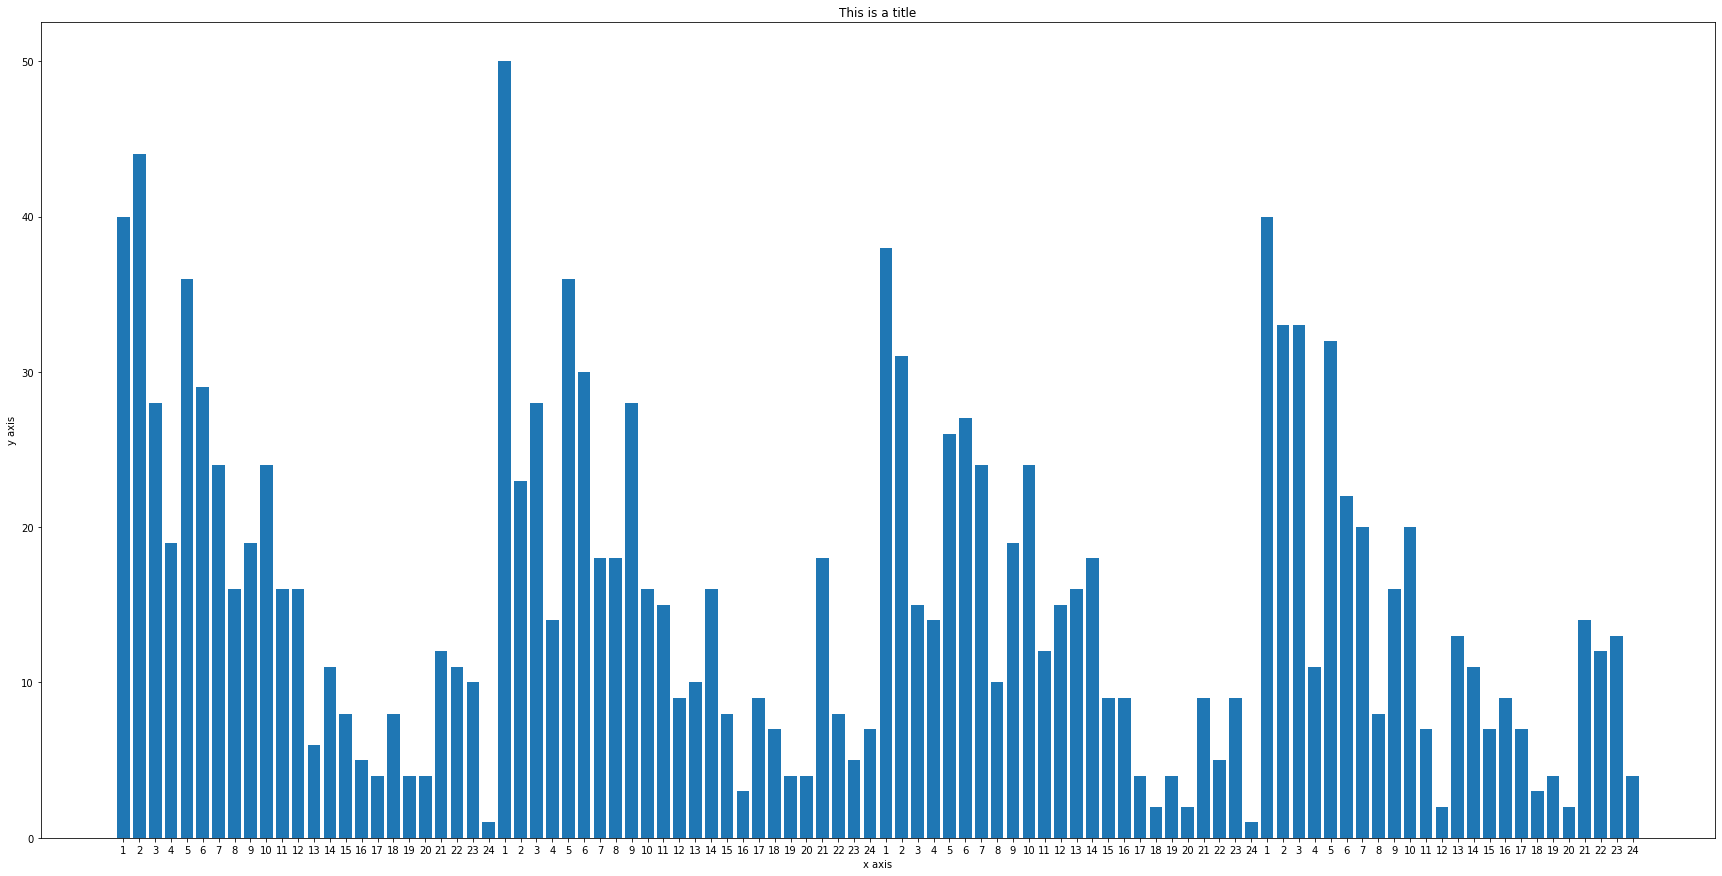

In [14]:

graph_df=season_df.loc[2019, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2018

Text(0, 0.5, 'y axis')

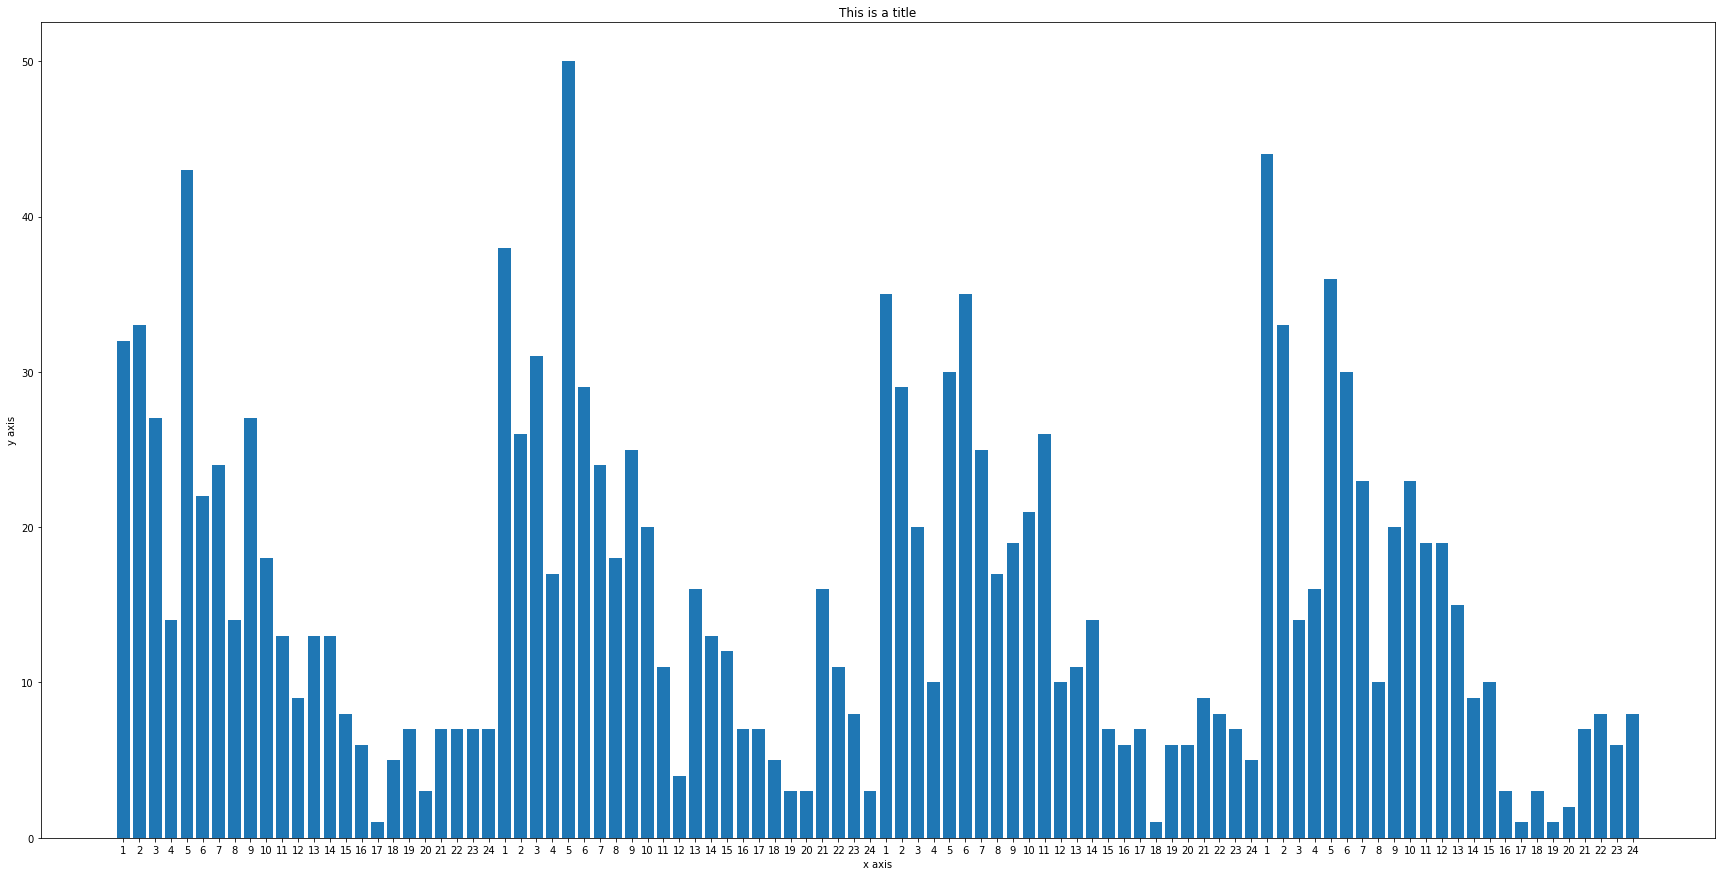

In [15]:

graph_df=season_df.loc[2018, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2017

Text(0, 0.5, 'y axis')

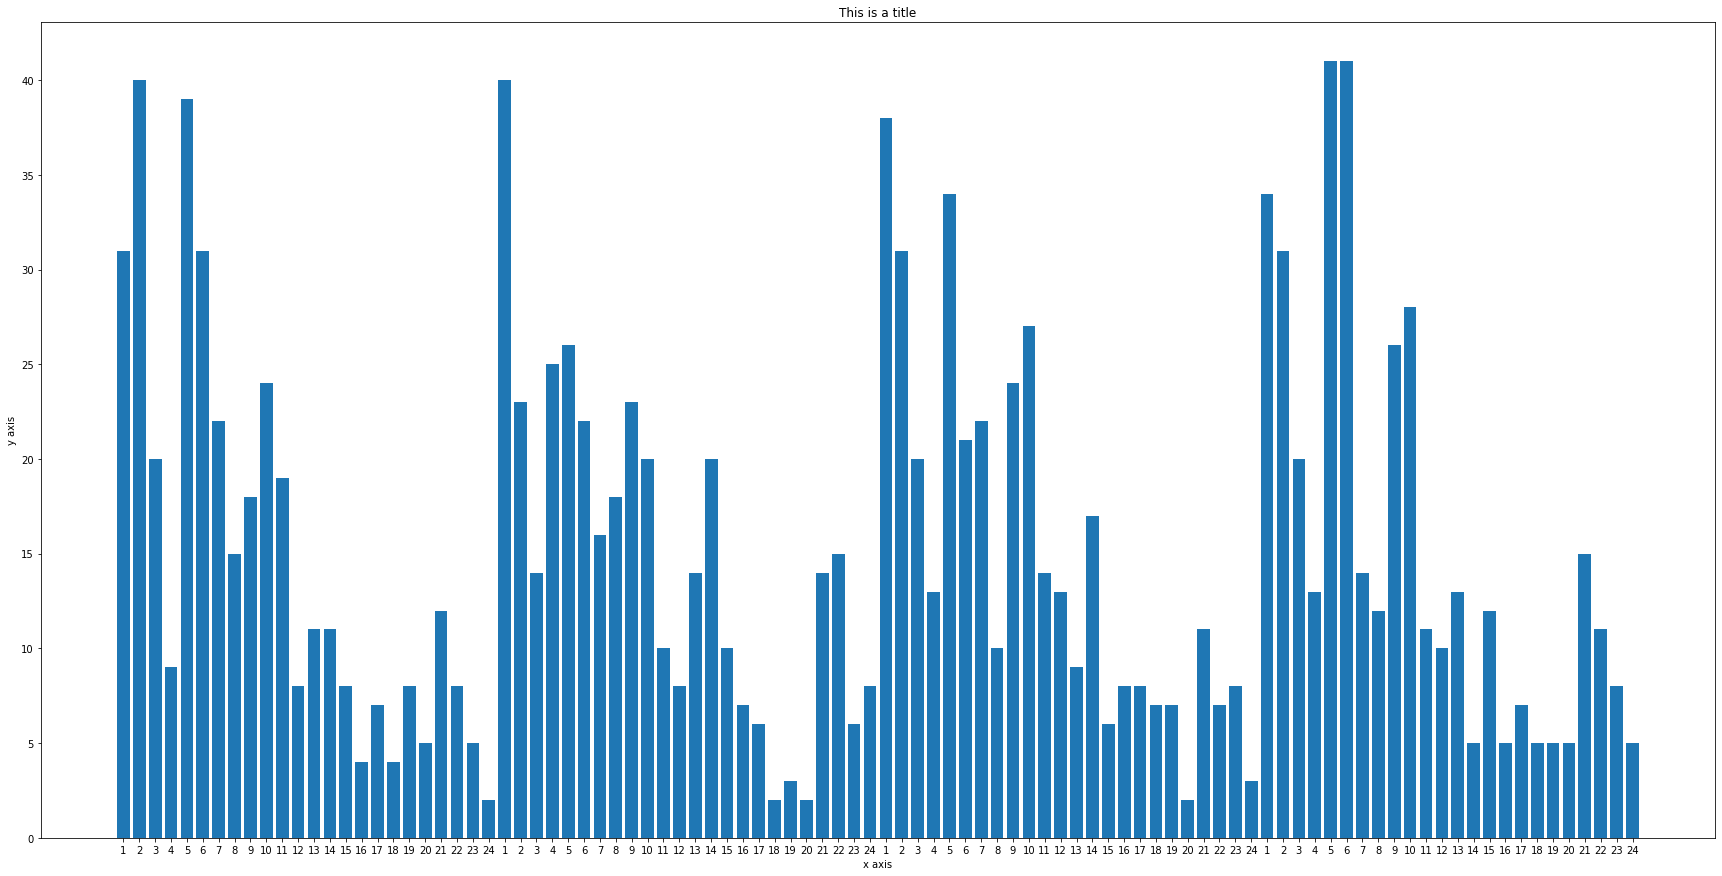

In [16]:

graph_df=season_df.loc[2017, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2015

Text(0, 0.5, 'y axis')

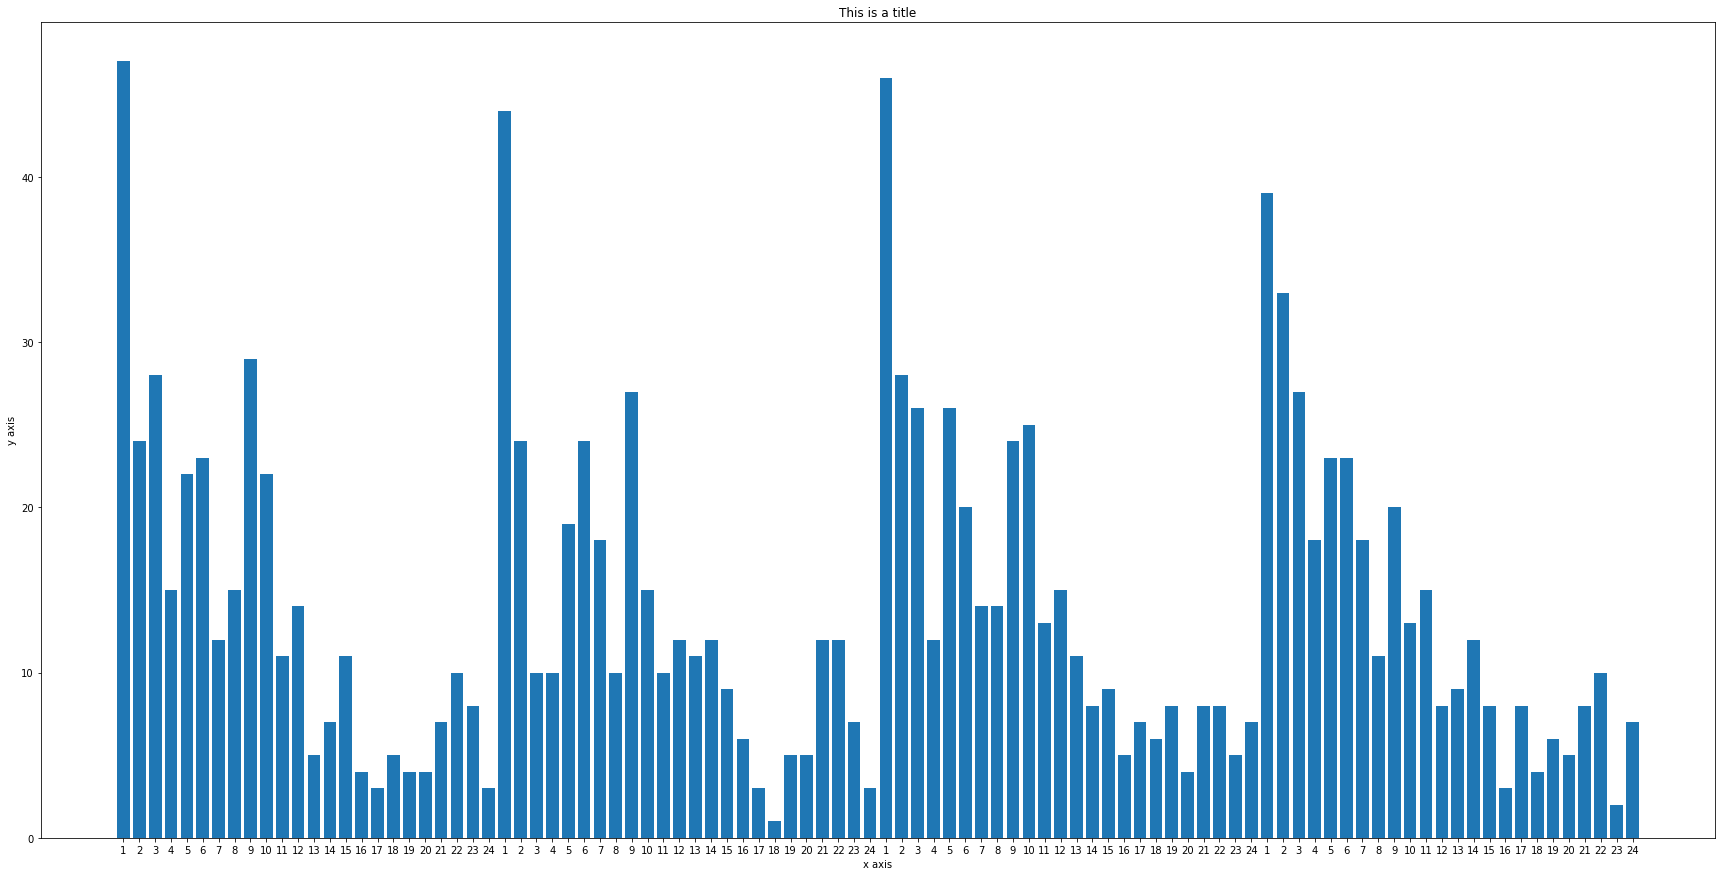

In [17]:

graph_df=season_df.loc[2015, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

# 季節　結果:

Text(0, 0.5, 'y axis')

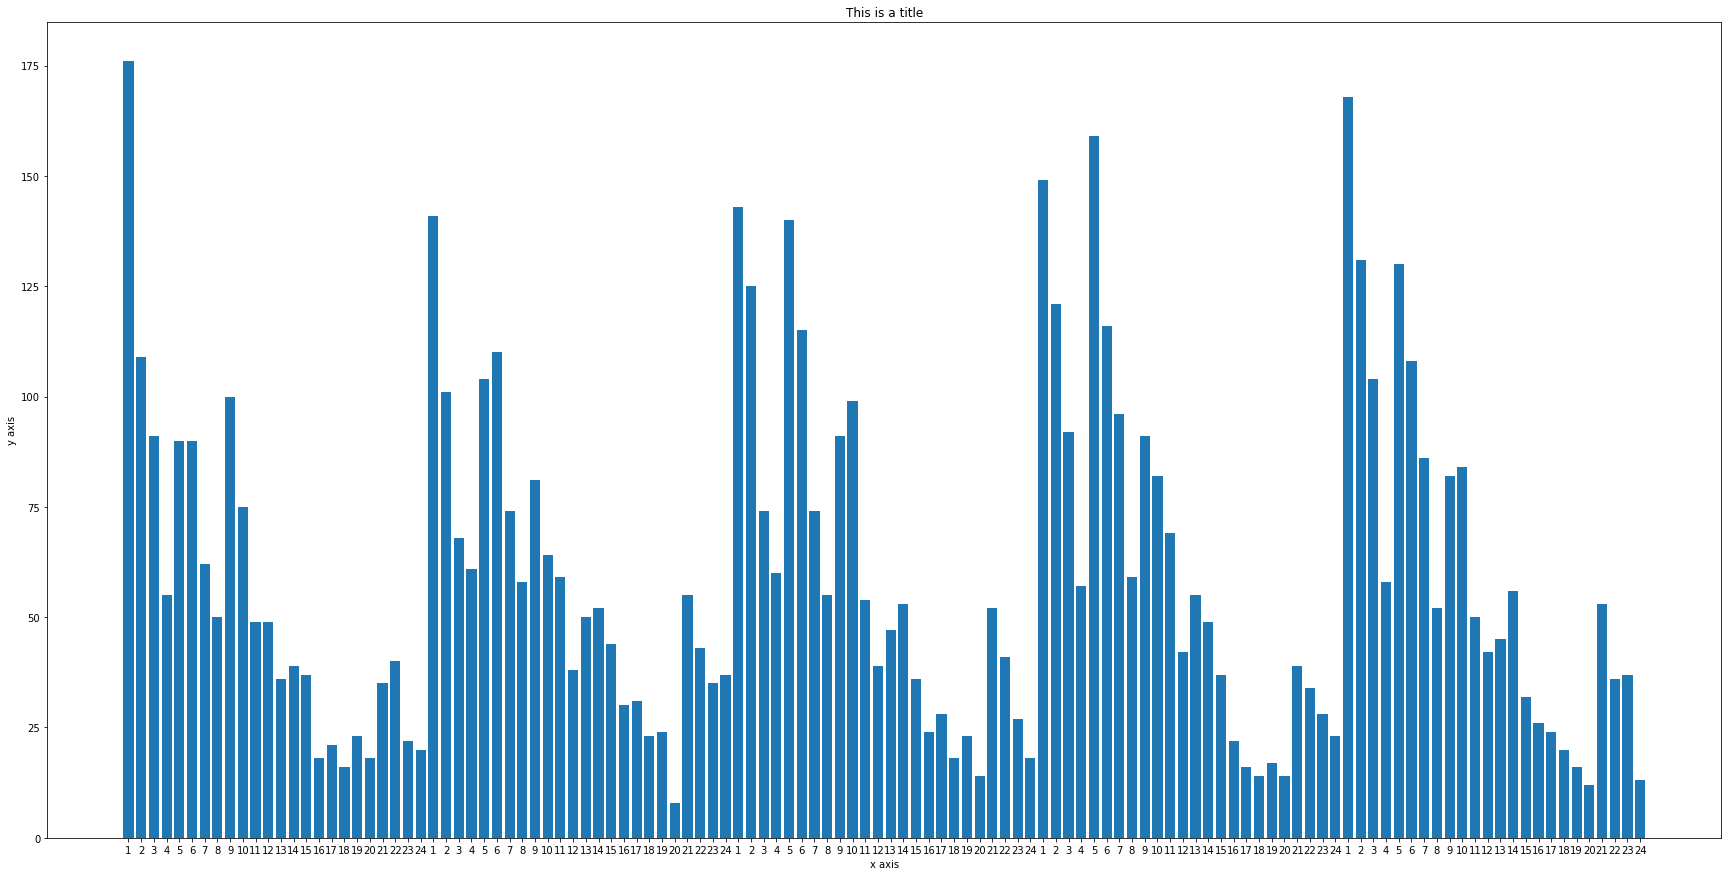

In [18]:

graph_df=group_year_df.loc[2015:2019, :]
graph_df
plt.figure(figsize=(30,15))
#Xラベル作成
x=[]
for i in range(5):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

In [19]:
group_season_df['date'].index.levels[2]

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], dtype='int64', name='result_com')

In [20]:
#train_df.to_csv('test.csv',encoding='utf-8')